   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.3 MB/s eta 0:00:00
✅ Model trained — MAE: 5.091 | R²: 0.850


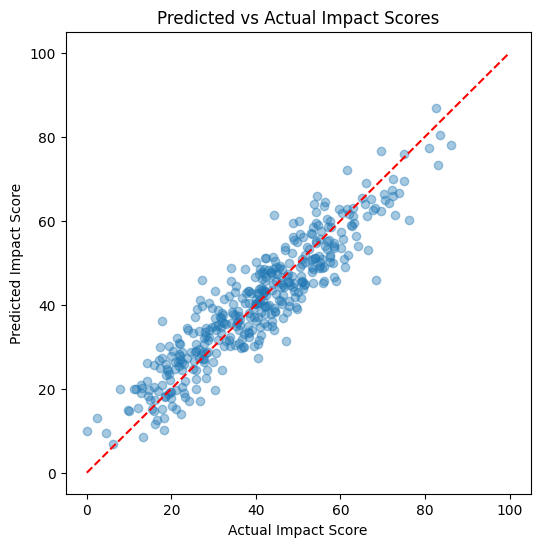

/tmp/ipython-input-964866020.py:117: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_X, show=True)


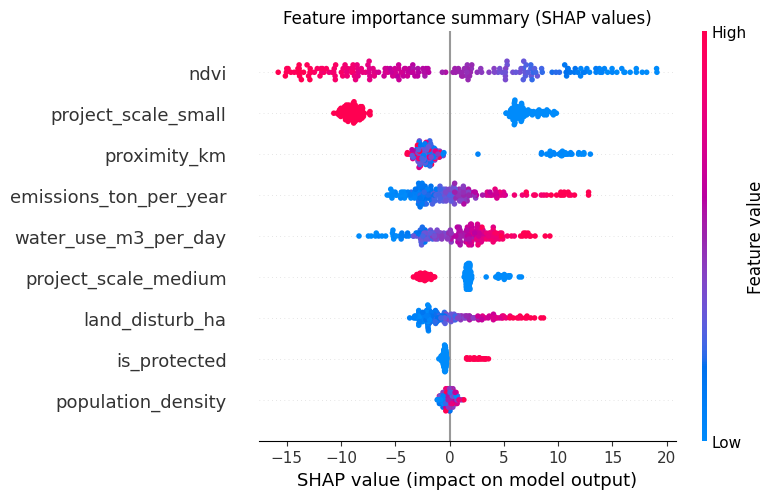

In [1]:
# AI for Environmental Impact Assessment for a Sustainable Future
# Colab-ready MVP Demonstration
# ============================================================

# Step 1: Install dependencies
!pip install pandas numpy scikit-learn xgboost shap matplotlib streamlit --quiet

# Step 2: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import shap
import joblib

# ============================================================
# Step 3: Generate synthetic environmental data
# ============================================================
def generate_synthetic_env_data(n=2000, seed=42):
    np.random.seed(seed)
    emissions = np.random.gamma(2, 10, n)
    water_use = np.random.normal(500, 200, n).clip(min=10)
    land_disturb = np.random.exponential(1.5, n)
    proximity = np.random.exponential(10, n)
    pop_density = np.random.normal(300, 250, n).clip(min=1)
    project_scale = np.random.choice(["small","medium","large"], size=n, p=[0.5,0.35,0.15])
    ndvi = np.random.uniform(0,1,n)
    is_protected = (proximity < 2).astype(int)

    # synthetic impact score (target)
    impact_score = (
        0.4 * (emissions / (emissions.max()+1)) +
        0.2 * (water_use / (water_use.max()+1)) +
        0.25 * (land_disturb / (land_disturb.max()+1)) +
        0.3 * (1 - ndvi) +
        0.15 * (is_protected) +
        0.2 * (np.where(project_scale=="large", 1,
                        np.where(project_scale=="medium", 0.5, 0)))
    )
    impact_score = (impact_score + np.random.normal(0,0.05,n))
    impact_score = (impact_score - impact_score.min()) / (impact_score.max()-impact_score.min())
    impact_score = (impact_score * 100).round(2)

    df = pd.DataFrame({
        "emissions_ton_per_year": emissions,
        "water_use_m3_per_day": water_use,
        "land_disturb_ha": land_disturb,
        "proximity_km": proximity,
        "population_density": pop_density,
        "project_scale": project_scale,
        "ndvi": ndvi,
        "is_protected": is_protected,
        "impact_score": impact_score
    })
    return df

df = generate_synthetic_env_data()
df.head()

# ============================================================
# Step 4: Preprocess & Split
# ============================================================
df = pd.get_dummies(df, columns=["project_scale"], drop_first=True)
X = df.drop("impact_score", axis=1)
y = df["impact_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ============================================================
# Step 5: Train XGBoost model
# ============================================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "seed": 42
}

bst = xgb.train(params, dtrain, num_boost_round=150)
preds = bst.predict(dtest)

mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"✅ Model trained — MAE: {mae:.3f} | R²: {r2:.3f}")

# ============================================================
# Step 6: Visualize predicted vs actual
# ============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.4)
plt.xlabel("Actual Impact Score")
plt.ylabel("Predicted Impact Score")
plt.title("Predicted vs Actual Impact Scores")
plt.plot([0,100],[0,100],"r--")
plt.show()

# ============================================================
# Step 7: Explainability with SHAP
# ============================================================
explainer = shap.TreeExplainer(bst)
sample_X = X_test.sample(200, random_state=42)
shap_values = explainer.shap_values(sample_X)

plt.title("Feature importance summary (SHAP values)")
shap.summary_plot(shap_values, sample_X, show=True)